In [5]:
# Cell 1: Setup and Imports

# --- Core Libraries ---
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import requests
# Cell 1: Setup and Imports (Partial)

import time # <--- ADD THIS LINE
# ... rest of your Cell 1 code ...

# --- Database & System Libraries ---
import os
from dotenv import load_dotenv
import logging
from datetime import datetime, timedelta

# --- Import Custom DB Connector ---
from common.database.MQSDBConnector import MQSDBConnector

# --- Notebook Configuration ---
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set_theme(style="whitegrid")

# Configure logging for better debugging and tracing.
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

# Load environment variables
load_dotenv()

print("Libraries imported and MQSDBConnector ready.")

Libraries imported and MQSDBConnector ready.


In [6]:
# Cell 2: Data Loading and Preparation (with Yearly Loop)

# --- 1. Load API Key ---
# (Assumes 'FMP_API_KEY' is in your .env file)
fmp_api_key = os.getenv("FMP_API_KEY")

if not fmp_api_key:
    logging.error("FMP_API_KEY not found in environment variables...")
    # raise ValueError("FMP_API_KEY not found.")

# --- 2. Define Data Fetching Function (Yearly Loop Version) ---

def _get_market_data(tickers_list: list, lookback_days: int, api_key: str) -> pd.DataFrame:
    """
    Fetches daily (end-of-day) historical data from the FMP API.
    
    ATTEMPT: This version loops by year to try and bypass API limits.
    WARNING: This will likely NOT work if the API key plan itself
             restricts historical data access to only 1 year.
    
    :param tickers_list: List of stock symbols
    :param lookback_days: How many days of data to fetch
    :param api_key: The FMP API key
    :return: Pandas DataFrame of historical records
    """
    
    # --- 1. Prepare Parameters ---
    if not tickers_list:
        logging.warning("No tickers provided. Returning empty DataFrame.")
        return pd.DataFrame()
        
    tickers_str = ",".join(tickers_list)
    
    # Calculate start and end years for the loop
    end_date = datetime.now()
    start_date = end_date - timedelta(days=lookback_days)
    
    start_year = start_date.year
    end_year = end_date.year # This will be the current year

    all_dfs = [] # List to hold DataFrame for each year
    
    logging.info(f"Starting yearly data fetch from {start_year} to {end_year} for {tickers_str}...")

    # --- 2. Loop Through Each Year ---
    for year in range(start_year, end_year + 1):
        
        # Define the date range for this specific year
        from_date_loop = f"{year}-01-01"
        to_date_loop = f"{year}-12-31"
        
        # Override 'to_date' if we are in the current year
        if year == end_year:
            to_date_loop = end_date.date().isoformat()

        logging.info(f"--- Fetching data for year: {year} ---")

        url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{tickers_str}"
        params = {"from": from_date_loop, "to": to_date_loop, "apikey": api_key}

        # --- Make API Request (per year) ---
        try:
            response = requests.get(url, params=params)
            response.raise_for_status() 
            data = response.json()
        except requests.exceptions.RequestException as e:
            logging.error(f"API request failed for {year}: {e}")
            continue # Skip to next year

        # --- Parse FMP Response (for this year) ---
        historical_data = []
        if isinstance(data, dict) and 'historical' in data:
            logging.info(f"Processing single ticker response for {year}")
            for record in data['historical']:
                record['symbol'] = tickers_str
                historical_data.append(record)
                
        elif isinstance(data, dict) and 'historicalStockList' in data:
            logging.info(f"Processing multi-ticker response for {year}")
            for stock in data['historicalStockList']:
                t_symbol = stock['symbol']
                for record in stock['historical']:
                    record['symbol'] = t_symbol
                    historical_data.append(record)
        else:
            logging.warning(f"No valid data found for {year}.")
            
        if historical_data:
            logging.info(f"Successfully parsed {len(historical_data)} data points for {year}.")
            all_dfs.append(pd.DataFrame(historical_data))
        else:
            logging.warning(f"No data returned from API for {year}.")
            
        # **CRUCIAL**: Wait for a moment to avoid API rate limits
        # (e.g., 0.5 - 1 second between calls)
        time.sleep(0.5) 

    # --- 3. Combine All DataFrames ---
    if not all_dfs:
        logging.warning("No data fetched for any year. Returning empty DataFrame.")
        return pd.DataFrame()
        
    df = pd.concat(all_dfs)

    # --- 4. Convert to DataFrame and Clean (Run once on the final DF) ---
    df.rename(columns={
        'date': 'timestamp',
        'close': 'close_price',
        'open': 'open_price',
        'high': 'high_price',
        'low': 'low_price',
        'symbol': 'ticker'
    }, inplace=True)

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    num_cols = [
        'open_price', 'high_price', 'low_price', 'close_price', 'adjClose',
        'volume', 'unadjustedVolume', 'change', 'changePercent', 'vwap'
    ]
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(subset=['timestamp', 'ticker', 'close_price'], inplace=True)
    df.sort_values(['timestamp', 'ticker'], inplace=True)
    
    logging.info(f"Successfully processed {len(df)} TOTAL data points from all years.")
    return df

# --- 3. Execute Data Fetching ---

tickers = ['AAPL', 'MSFT', 'GOOG'] 
model_lookback_days = 365 * 10 # ~20 years

if fmp_api_key:
    all_data = _get_market_data(tickers, model_lookback_days, fmp_api_key)
    print(f"Loaded {len(all_data)} rows of end-of-day data.")
    print("Data head:")
    print(all_data.head())
    print("\nData tail:")
    print(all_data.tail())
else:
    print("Skipping data load because FMP_API_KEY is not set.")
    all_data = pd.DataFrame()

Loaded 8247 rows of end-of-day data.
Data head:
     timestamp  open_price  high_price  low_price  close_price  adjClose  \
251 2015-01-02     27.8500     27.8600    26.8400      27.3300   24.2300   
755 2015-01-02     26.3800     26.4900    26.1300      26.1700   26.0500   
503 2015-01-02     46.6600     47.4200    46.5400      46.7600   39.8700   
250 2015-01-05     27.0700     27.1600    26.3500      26.5600   23.5500   
754 2015-01-05     26.0900     26.1500    25.5800      25.6200   25.5000   

        volume  unadjustedVolume  change  changePercent    vwap  \
251  212818504         212818504 -0.5150        -1.8700 27.4700   
755   29011360          29011360 -0.2094        -0.7961 26.2925   
503   27913900          27913900  0.1000         0.2143 46.8450   
250  257142000         257142000 -0.5100        -1.8800 26.7850   
754   41196796          41196796 -0.4682        -1.8000 25.8600   

              label  changeOverTime ticker  
251  January 02, 15         -0.0187   AAPL  
75

In [7]:
####cell 3: Data Preparation for Modeling

import numpy as np
import pandas as pd
import logging

# Ensure all_data is loaded from the previous cell.
# This simple check assumes 'all_data' is a global DataFrame.
if 'all_data' not in globals() or all_data.empty:
    logging.error("all_data DataFrame not found or is empty. Please run Cell 2 first.")
    # In a real notebook, you might 'raise' an error, but here we'll just log.
    
def engineer_features(df):
    """
    Engineers predictive features (X) and an outcome variable (Y)
    from the raw market data.
    
    X variables (predictors):
    - past_return_21d: 1-month (21 trading days) past return
    - past_vol_21d: 1-month past volatility (std dev of daily returns)
    - past_return_63d: 3-month (63 trading days) past return
    - past_vol_63d: 3-month past volatility
    - past_return_252d: 1-year (252 trading days) past return
    
    Y variable (outcome):
    - target_return_21d: 1-month future return
    """
    logging.info("Starting feature engineering...")
    
    # Work on a copy to avoid SettingWithCopyWarning
    data = df.copy()
    
    # Ensure data is sorted for time-series operations
    data.sort_values(['ticker', 'timestamp'], inplace=True)
    
    # Calculate daily returns as the basis for volatility
    daily_returns = data.groupby('ticker')['close_price'].pct_change()
    
    # --- Create X Variables (Predictors) ---
    
    # Group by ticker to apply rolling/shifting operations correctly
    grouped = data.groupby('ticker')
    
    # 1. Past Returns (Momentum)
    data['past_return_21d'] = grouped['close_price'].pct_change(21)
    data['past_return_63d'] = grouped['close_price'].pct_change(63)
    data['past_return_252d'] = grouped['close_price'].pct_change(252)

    # 2. Past Volatility
    # We use .transform() to align the rolling std dev with the original DataFrame index
    data['past_vol_21d'] = daily_returns.groupby(data['ticker']).transform(lambda x: x.rolling(21).std())
    data['past_vol_63d'] = daily_returns.groupby(data['ticker']).transform(lambda x: x.rolling(63).std())

    # --- Create Y Variable (Target) ---
    
    # Calculate 21-day FUTURE return. We shift(-21) to pull future data back.
    data['target_return_21d'] = grouped['close_price'].shift(-21) / data['close_price'] - 1
    
    # --- Clean Up and Return ---
    
    # Drop rows with NaNs created by rolling windows or target shifting
    # We now have X and Y variables in the same row.
    data.dropna(inplace=True)
    
    logging.info(f"Feature engineering complete. {len(data)} rows remain after NaN removal.")
    
    return data

# --- 1. Engineer Features ---
processed_data = engineer_features(all_data)

# --- 2. Define X and Y Column Names ---
# These are our K=5 predictive variables
FEATURE_COLS = [
    'past_return_21d',
    'past_vol_21d',
    'past_return_63d',
    'past_vol_63d',
    'past_return_252d'
]
TARGET_COL = 'target_return_21d'

# --- 3. Split into Training and Testing Sets ---
# We use a date-based split for time-series data, as seen in the paper.
# Train on 2005-2019, Test on 2020-2025.
split_date = pd.to_datetime('2020-01-01')

train_df = processed_data[processed_data['timestamp'] < split_date]
test_df = processed_data[processed_data['timestamp'] >= split_date]

# Separate X (predictors) and y (target)
X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]

X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGET_COL]

print("Cell 3: Data Preparation Complete.")
print(f"Total processed rows: {len(processed_data)}")
print(f"Training set: {len(X_train)} rows (up to {split_date.date()})")
print(f"Testing set: {len(X_test)} rows (from {split_date.date()})")
print("\nPredictive Variables (X):")
print(FEATURE_COLS)
print("\nOutcome Variable (Y):")
print(TARGET_COL)
print("\nX_train head:")
print(X_train.head())

Cell 3: Data Preparation Complete.
Total processed rows: 7428
Training set: 3018 rows (up to 2020-01-01)
Testing set: 4410 rows (from 2020-01-01)

Predictive Variables (X):
['past_return_21d', 'past_vol_21d', 'past_return_63d', 'past_vol_63d', 'past_return_252d']

Outcome Variable (Y):
target_return_21d

X_train head:
     past_return_21d  past_vol_21d  past_return_63d  past_vol_63d  \
251          -0.0939        0.0156          -0.0457        0.0157   
250          -0.1083        0.0162          -0.0729        0.0160   
249          -0.1539        0.0138          -0.0952        0.0162   
248          -0.1846        0.0158          -0.1296        0.0170   
247          -0.1800        0.0160          -0.1147        0.0169   

     past_return_252d  
251           -0.0362  
250           -0.0331  
249           -0.0523  
248           -0.1050  
247           -0.1334  


In [8]:
##cell 4: Pre-computation and Relevance Functions

import numpy as np
import pandas as pd
import logging

# This cell assumes X_train exists from Cell 3
if 'X_train' not in globals():
    logging.error("X_train not found. Please run Cell 3 first.")
    # Create a dummy DataFrame to prevent crashes, though logic will be flawed
    X_train = pd.DataFrame(np.random.rand(100, 5), 
                           columns=['past_return_21d', 'past_vol_21d', 
                                    'past_return_63d', 'past_vol_63d', 
                                    'past_return_252d'])

# --- Cell 3 (Template): Pre-computation on Training Data ---

def compute_training_statistics(X_train_df):
  """
  Computes the mean vector and inverse covariance matrix
  from the training data, as described in [cite: 149].
  
  These are the "x-bar" and "Omega-inverse" used for all
  Mahalanobis distance calculations.
  """
  logging.info(f"Computing statistics on {len(X_train_df)} training rows...")
  
  # 1. Calculate the mean vector (x-bar) [cite: 149]
  # .values creates a 1D numpy array: (K,)
  x_mean = X_train_df.mean().values
  
  # 2. Calculate the covariance matrix (Omega)
  cov_matrix = X_train_df.cov().values
  
  # 3. Calculate the inverse covariance matrix (Omega-inverse) [cite: 149]
  # This is the key component for Mahalanobis distance
  try:
    inv_cov_matrix = np.linalg.inv(cov_matrix)
  except np.linalg.LinAlgError:
    logging.error("Covariance matrix is singular. Cannot compute inverse.")
    # Add a small amount of "jitter" (ridge regression) to the diagonal
    # This helps stabilize the matrix if variables are highly collinear
    logging.warning("Adding small identity matrix 'jitter' to stabilize...")
    cov_matrix_reg = cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6
    inv_cov_matrix = np.linalg.inv(cov_matrix_reg)

  logging.info(f"Computed x_mean ({x_mean.shape}) and inv_cov_matrix ({inv_cov_matrix.shape}).")
  
  return x_mean, inv_cov_matrix, X_train_df.columns.tolist()

# --- Cell 4 (Template): Core Helper Functions (Relevance) ---

def calculate_mahalanobis_distance(vec1, vec2, inv_cov_matrix):
  """
  Calculates the *squared* Mahalanobis distance between two vectors.
  (x_i - x_t) * Omega^-1 * (x_i - x_t)'
  
  Args:
    vec1 (np.array): 1D array of shape (K,)
    vec2 (np.array): 1D array of shape (K,)
    inv_cov_matrix (np.array): 2D array of shape (K, K)
    
  Returns:
    float: The squared Mahalanobis distance.
  """
  # Ensure inputs are numpy arrays (e.g., from df.values)
  diff = vec1 - vec2  # Shape (K,)
  
  # We use (diff @ inv_cov @ diff) which is equivalent to
  # (diff @ inv_cov @ diff.T) for 1D arrays in numpy.
  # This calculates: (1, K) @ (K, K) @ (K, 1) -> scalar
  m_dist_sq = diff @ inv_cov_matrix @ diff
  
  return m_dist_sq

def calculate_relevance(x_i, x_t, x_mean, inv_cov_matrix):
  """
  Calculates the relevance of a past observation (x_i) to a
  current prediction task (x_t), based on Equation 1 [cite: 141].
  
  Args:
    x_i (np.array): A single past observation vector (shape K,)
    x_t (np.array): The current prediction task vector (shape K,)
    x_mean (np.array): The mean vector of training data (shape K,)
    inv_cov_matrix (np.array): The inverse covariance matrix (shape K, K)
    
  Returns:
    float: The total relevance score (r_it).
  """

  # 1. Similarity (sim) component, Equation 2 [cite: 142]
  # This is the distance between the past obs and current task
  sim_component = calculate_mahalanobis_distance(x_i, x_t, inv_cov_matrix)
  
  # 2. Informativeness of past observation (info(x_i)), Equation 3 [cite: 143]
  # This is the distance between the past obs and the "average" obs
  info_i = calculate_mahalanobis_distance(x_i, x_mean, inv_cov_matrix)
  
  # 3. Informativeness of current task (info(x_t)), Equation 4 [cite: 144]
  # This is the distance between the current task and the "average" obs
  info_t = calculate_mahalanobis_distance(x_t, x_mean, inv_cov_matrix)
  
  # 4. Total Relevance (r_it), Equation 1 [cite: 141]
  r_it = (-0.5 * sim_component) + 0.5 * (info_i + info_t)
  
  return r_it

# --- Execute Pre-computation ---
print("Cell 4: Running Pre-computation...")

# Compute and store the fundamental training statistics
# These will be used for every relevance calculation
full_train_stats = {}
(
    full_train_stats['x_mean'],
    full_train_stats['inv_cov'],
    full_train_stats['vars']
) = compute_training_statistics(X_train)

print("\nRelevance helper functions defined.")
print("Training statistics (mean, inv_cov) computed and stored.")
print(f"Variables used: {full_train_stats['vars']}")

Cell 4: Running Pre-computation...

Relevance helper functions defined.
Training statistics (mean, inv_cov) computed and stored.
Variables used: ['past_return_21d', 'past_vol_21d', 'past_return_63d', 'past_vol_63d', 'past_return_252d']


In [9]:
##cell 5: Prediction and Fit Helper Functions

import numpy as np
import pandas as pd
import logging

# This cell assumes X_train, y_train, and the calculate_relevance function
# from Cell 4 are available in the global scope.
if 'X_train' not in globals() or 'y_train' not in globals():
    logging.error("X_train or y_train not found. Please run Cell 3 first.")
    # Define dummies
    X_train = pd.DataFrame(np.random.rand(100, 5))
    y_train = pd.Series(np.random.rand(100))
if 'calculate_relevance' not in globals():
    logging.error("calculate_relevance not found. Please run Cell 4 first.")
    def calculate_relevance(x_i, x_t, x_mean, inv_cov_matrix):
        return np.random.rand()

def get_relevance_for_task(x_t, X_train, x_mean, inv_cov):
  """
  Calculates relevance scores for ALL past observations (x_i)
  against a SINGLE current task (x_t).
  
  Args:
    x_t (np.array): The current prediction task vector (K,)
    X_train (pd.DataFrame): All past observations (N, K)
    x_mean (np.array): Mean vector from training (K,)
    inv_cov (np.array): Inverse covariance matrix (K, K)
    
  Returns:
    pd.Series: Relevance scores, indexed by X_train.index
  """
  # Use .apply(axis=1) to iterate through each row (x_i)
  # and call calculate_relevance for each one.
  # x_i.values passes the row as a numpy array, which is fast.
  relevance_scores = X_train.apply(
      lambda x_i: calculate_relevance(x_i.values, x_t, x_mean, inv_cov),
      axis=1
  )
  return relevance_scores

def calculate_prediction_weights(relevance_scores, r_threshold_quantile=0.0):
  """
  Calculates observation weights (w_it) based on relevance
  and a censoring threshold, per Equations 7-9.
  
  If r_threshold_quantile is 0.0, this function uses the
  linear regression equivalent weights from Equation 6.
  
  Args:
    relevance_scores (pd.Series): Series of relevance scores for all x_i
    r_threshold_quantile (float): The quantile for censoring (e.g., 0.2, 0.5)
    
  Returns:
    tuple: (weights (pd.Series), retained_mask (pd.Series))
  """
  N = len(relevance_scores)
  
  # --- Handle edge cases ---
  if N < 2:
      logging.warning("Not enough observations to calculate weights.")
      return pd.Series(np.nan, index=relevance_scores.index), \
             pd.Series(False, index=relevance_scores.index)
             
  # --- Linear Regression Case (Eq 6) ---
  # This is the default if no threshold is applied (quantile=0)
  if r_threshold_quantile == 0.0:
      weights = (1 / N) + (1 / (N - 1)) * relevance_scores
      retained_mask = pd.Series(True, index=relevance_scores.index)
      return weights, retained_mask

  # --- Censored Case (Eq 7-9) ---
  
  # 1. Determine the relevance threshold value (r*)
  r_star = relevance_scores.quantile(r_threshold_quantile)
  
  # 2. Identify retained (delta=1) and censored (delta=0) observations
  retained_mask = relevance_scores >= r_star
  
  # 3. Calculate n, phi, r_sub_avg, etc.
  n = retained_mask.sum()
  
  # Handle edge case where n is too small to calculate variance or (n-1)
  if n < 2:
      # Revert to linear regression weights (Eq 6)
      logging.warning(f"Quantile {r_threshold_quantile} resulted in n < 2. "
                      f"Reverting to linear weights (Eq 6).")
      weights = (1 / N) + (1 / (N - 1)) * relevance_scores
      retained_mask = pd.Series(True, index=relevance_scores.index)
      return weights, retained_mask

  phi = n / N
  retained_scores = relevance_scores[retained_mask]
  r_sub_avg = retained_scores.mean()

  # 4. Calculate the scaling factor (lambda^2) (Eq 9)
  # Note: (x**2).sum() / (n-1) is the variance without subtracting the mean,
  # which matches the paper's definition of variance of relevance.
  var_r_full_sum = (relevance_scores**2).sum()
  var_r_retained_sum = (retained_scores**2).sum()

  if (N - 1) == 0 or (n - 1) == 0 or var_r_retained_sum == 0:
      lambda_sq = 1.0 # Avoid division by zero
  else:
      var_r_full = var_r_full_sum / (N - 1)
      var_r_retained = var_r_retained_sum / (n - 1)
      lambda_sq = var_r_full / var_r_retained

  # 5. Calculate final weights (w_it_retained) for all i (Eq 7)
  # `delta(r_it) * r_it` is just the scores where retained, 0 otherwise
  delta_r_it = relevance_scores.where(retained_mask, 0.0)
  
  term1 = 1 / N
  term2_multiplier = lambda_sq / (n - 1)
  term3_base = (delta_r_it - phi * r_sub_avg)
  
  weights = term1 + term2_multiplier * term3_base
  
  return weights, retained_mask

def calculate_fit(weights, outcomes):
  """
  Calculates the Fit for a prediction task, which is the
  squared correlation of relevance weights and outcomes, per Eq. 11.
  
  Args:
    weights (pd.Series): The prediction weights (w_it)
    outcomes (pd.Series): The past outcomes (y_i)
    
  Returns:
    float: The fit score (rho^2)
  """
  # Ensure indices align for correlation
  weights_aligned, outcomes_aligned = weights.align(outcomes)
  
  if weights_aligned.std() == 0 or outcomes_aligned.std() == 0:
      return 0.0 # Cannot correlate if one variable is constant

  rho = np.corrcoef(weights_aligned, outcomes_aligned)[0, 1]
  
  if np.isnan(rho):
      return 0.0 # Handle potential NaN from std dev=0 or other issues
      
  return rho**2

def calculate_asymmetry(weights, outcomes, retained_mask):
  """
  Calculates asymmetry per Equation 13.
  
  Args:
    weights (pd.Series): The prediction weights (w_it)
    outcomes (pd.Series): The past outcomes (y_i)
    retained_mask (pd.Series): Boolean mask of retained samples
  
  Returns:
    float: The asymmetry score
  """
  # Align all data
  # FIX: Chain the alignments. align can only handle two Series at a time.
  # 1. Align weights and outcomes
  weights_aligned, outcomes_aligned = weights.align(outcomes)
  # 2. Align the mask to the *new* aligned index of weights
  weights_aligned, retained_mask_aligned = weights_aligned.align(retained_mask)
  # 3. Align the outcomes to the *final* aligned index as well
  outcomes_aligned, retained_mask_aligned = outcomes_aligned.align(retained_mask_aligned)

  # 1. Get weights and outcomes for retained subsample (w_t_plus)
  # FIX: Use the new aligned variables
  w_retained = weights_aligned[retained_mask_aligned]
  y_retained = outcomes_aligned[retained_mask_aligned]
  
  # 2. Get weights and outcomes for censored subsample (w_t_minus)
  # FIX: Use the new aligned variables
  w_censored = weights_aligned[~retained_mask_aligned]
  y_censored = outcomes_aligned[~retained_mask_aligned]

  # 3. Calculate correlations, handling edge cases
  rho_plus = 0.0
  if len(w_retained) >= 2 and w_retained.std() > 0 and y_retained.std() > 0:
      rho_plus = np.corrcoef(w_retained, y_retained)[0, 1]
      if np.isnan(rho_plus): rho_plus = 0.0
      
  rho_minus = 0.0
  if len(w_censored) >= 2 and w_censored.std() > 0 and y_censored.std() > 0:
      rho_minus = np.corrcoef(w_censored, y_censored)[0, 1]
      if np.isnan(rho_minus): rho_minus = 0.0

  # 4. Return asymmetry (Eq 13)
  return 0.5 * (rho_plus - rho_minus)**2

def calculate_adjusted_fit(fit, asymmetry, K):
  """
  Calculates adjusted fit per Equation 14.
  K is the number of predictive variables in this calibration.
  
  Args:
    fit (float): The fit score (from calculate_fit)
    asymmetry (float): The asymmetry score (from calculate_asymmetry)
    K (int): Number of variables used
    
  Returns:
    float: The adjusted fit score
  """
  return K * (fit + asymmetry)

print("Cell 5: Prediction and Fit helper functions defined.")

Cell 5: Prediction and Fit helper functions defined.


In [10]:
##cell 6: Example Calculation for a Single Prediction Task

import numpy as np
import pandas as pd
import logging

# --- Setup: Ensure all previous cells are run ---
# This cell needs:
# - From Cell 3: X_train, y_train, X_test
# - From Cell 4: full_train_stats (x_mean, inv_cov), calculate_relevance
# - From Cell 5: get_relevance_for_task, calculate_prediction_weights,
#                calculate_fit, calculate_asymmetry, calculate_adjusted_fit

if 'X_test' not in globals() or X_test.empty:
    logging.error("X_test not found. Please run Cells 3, 4, and 5 first.")
    # Create a dummy x_t to prevent crash
    x_t = np.random.rand(5)
    x_t_index = "dummy_index"
else:
    # --- 1. Select a Single Prediction Task (x_t) ---
    # We'll pick the first row from our test set
    x_t_series = X_test.iloc[0]
    x_t = x_t_series.values
    x_t_index = x_t_series.name
    
    print(f"--- Running example calculation for task: {x_t_index} ---")
    print(f"Task vector (x_t):\n{x_t_series.to_string()}\n")

# --- 2. Get Relevance Scores ---
# This calculates relevance for all N training rows against our single x_t
print("Calculating relevance scores...")
relevance_scores = get_relevance_for_task(
    x_t,
    X_train,
    full_train_stats['x_mean'],
    full_train_stats['inv_cov']
)
print(f"Top 5 most relevant past observations:\n{relevance_scores.nlargest(5)}\n")
print(f"Bottom 5 least relevant past observations:\n{relevance_scores.nsmallest(5)}\n")


# --- 3. Run Calculation for Linear Case (Eq 6) ---
print("--- Scenario 1: Linear Regression (Quantile = 0.0) ---")
K_vars = X_train.shape[1] # K = 5 variables
thresh_lin = 0.0

weights_lin, mask_lin = calculate_prediction_weights(
    relevance_scores, 
    thresh_lin
)

fit_lin = calculate_fit(weights_lin, y_train)

# Asymmetry is 0 for linear case (mask is all True)
asym_lin = calculate_asymmetry(weights_lin, y_train, mask_lin)

adj_fit_lin = calculate_adjusted_fit(fit_lin, asym_lin, K_vars)

# The final prediction is the weighted average of past outcomes
pred_lin = (weights_lin * y_train).sum()

print(f"  Weights (w_it) head:\n{weights_lin.head().to_string()}\n")
print(f"  Prediction (y_t): {pred_lin:.6f}")
print(f"  Fit (rho^2):      {fit_lin:.6f}")
print(f"  Asymmetry:        {asym_lin:.6f}")
print(f"  Adjusted Fit:     {adj_fit_lin:.6f}")


# --- 4. Run Calculation for Censored Case (Eq 7-9) ---
print("\n--- Scenario 2: Censored RBP (Quantile = 0.2) ---")
thresh_cen = 0.2 # Retain top 80% most relevant

weights_cen, mask_cen = calculate_prediction_weights(
    relevance_scores, 
    thresh_cen
)

fit_cen = calculate_fit(weights_cen, y_train)
asym_cen = calculate_asymmetry(weights_cen, y_train, mask_cen)
adj_fit_cen = calculate_adjusted_fit(fit_cen, asym_cen, K_vars)
pred_cen = (weights_cen * y_train).sum()

print(f"  Relevance Threshold (r*): {relevance_scores.quantile(thresh_cen):.6f}")
print(f"  Retained 'n' obs:       {mask_cen.sum()} / {len(mask_cen)}")
print(f"  Weights (w_it) head:\n{weights_cen.head().to_string()}\n")
print(f"  Prediction (y_t): {pred_cen:.6f}")
print(f"  Fit (rho^2):      {fit_cen:.6f}")
print(f"  Asymmetry:        {asym_cen:.6f}")
print(f"  Adjusted Fit:     {adj_fit_cen:.6f}")

print("\nCell 6: Example calculation complete.")

--- Running example calculation for task: 252 ---
Task vector (x_t):
past_return_21d    0.1370
past_vol_21d       0.0106
past_return_63d    0.3718
past_vol_63d       0.0110
past_return_252d   0.9020

Calculating relevance scores...
Top 5 most relevant past observations:
4   16.8832
2   16.5534
5   16.4823
3   16.2215
0   16.1350
dtype: float64

Bottom 5 least relevant past observations:
130   -14.3899
129   -13.6828
131   -13.2236
128   -13.2143
124   -13.0275
dtype: float64

--- Scenario 1: Linear Regression (Quantile = 0.0) ---
  Weights (w_it) head:
251   -0.0019
250   -0.0021
249   -0.0027
248   -0.0031
247   -0.0031

  Prediction (y_t): -0.022493
  Fit (rho^2):      0.032610
  Asymmetry:        0.016305
  Adjusted Fit:     0.244576

--- Scenario 2: Censored RBP (Quantile = 0.2) ---
  Relevance Threshold (r*): -3.346628
  Retained 'n' obs:       2414 / 3018
  Weights (w_it) head:
251   -0.0005
250   -0.0005
249   -0.0005
248   -0.0005
247   -0.0005

  Prediction (y_t): -0.026676
  

In [11]:
##cell 7: Full Grid Processing for One Prediction Task

import numpy as np
import pandas as pd
import logging
import itertools # <-- NEW IMPORT for variable combinations

# --- Setup: Ensure all previous cells are run ---
# This cell needs:
# - From Cell 3: X_train, y_train, X_test
# - From Cell 4: compute_training_statistics, get_relevance_for_task
# - From Cell 5: calculate_prediction_weights, calculate_fit,
#                calculate_asymmetry, calculate_adjusted_fit

if 'X_train' not in globals():
    logging.error("X_train not found. Please run Cells 3, 4, and 5 first.")
    # Define dummies
    X_train = pd.DataFrame(np.random.rand(100, 5), columns=[f'V{i}' for i in range(5)])
    X_test = X_train.copy()
    y_train = pd.Series(np.random.rand(100))

# --- New Helper Function for Grid Columns ---

def get_variable_combinations(all_columns):
  """
  Generates all 2^K - 1 non-empty subsets of variables.
  
  Args:
    all_columns (list): List of column names
    
  Returns:
    list of tuples: Each tuple is a variable combination
  """
  combinations = []
  for k in range(1, len(all_columns) + 1):
    # Get all combinations of length k
    for combo in itertools.combinations(all_columns, k):
      combinations.append(combo)
  return combinations

# --- Core Grid Processing Function ---

def process_grid_for_one_task(x_t_series, X_train, y_train):
  """
  Builds the entire prediction grid (Exhibit 1) for a
  single prediction task (x_t_series).
  
  Args:
    x_t_series (pd.Series): The current prediction task (K,)
    X_train (pd.DataFrame): All past observations (N, K)
    y_train (pd.Series): All past outcomes (N,)
    
  Returns:
    pd.DataFrame: A DataFrame of [params, prediction, adj_fit]
  """
  
  # --- 1. Define the Grid ---
  
  # Columns: All 2^K - 1 combinations of variables
  variable_combinations = get_variable_combinations(X_train.columns)
  
  # Rows: Relevance thresholds
  relevance_thresholds = [0.0, 0.2, 0.5, 0.8]
  
  logging.info(f"Processing grid for one task: "
               f"{len(variable_combinations)} var combos x "
               f"{len(relevance_thresholds)} thresholds = "
               f"{len(variable_combinations) * len(relevance_thresholds)} cells.")

  # --- 2. Initialize Grid Results ---
  grid_results = [] # Store (cell_params, prediction, adjusted_fit)
  
  # --- 3. Iterate through Grid Cells (theta) ---
  
  for var_combo_tuple in variable_combinations:
    # Convert tuple to list for pandas indexing
    var_combo = list(var_combo_tuple)
    K = len(var_combo)
    
    # --- 3a. Setup for this Variable Subset ---
    X_train_sub = X_train[var_combo]
    x_t_sub = x_t_series[var_combo].values # .values to make it a np array
    
    # Re-compute stats for this *subset*
    # This is critical: x_mean and inv_cov are specific to the var subset
    x_mean_sub, inv_cov_sub, _ = compute_training_statistics(X_train_sub)
    
    # Get relevance scores for this task, using this subset
    relevance_scores = get_relevance_for_task(
        x_t_sub, X_train_sub, x_mean_sub, inv_cov_sub
    )
    
    # Iterate through all relevance thresholds (rows)
    for r_thresh in relevance_thresholds:
      # --- 3b. Process this Cell (theta) ---
      cell_params = {'vars': var_combo_tuple, 'thresh': r_thresh, 'K': K}
      
      # 1. Get prediction weights
      weights, mask = calculate_prediction_weights(relevance_scores, r_thresh)
      
      # 2. Get cell prediction (y_hat_theta)
      # Ensure indices align between weights and y_train before summing
      y_hat_theta = (weights * y_train.align(weights)[0]).sum()
      
      # 3. Get cell reliability
      fit = calculate_fit(weights, y_train)
      asymmetry = calculate_asymmetry(weights, y_train, mask)
      adj_fit = calculate_adjusted_fit(fit, asymmetry, K)
      
      # 4. Store cell results
      grid_results.append({
          'params': cell_params, 
          'prediction': y_hat_theta, 
          'adj_fit': adj_fit
      })

  return pd.DataFrame(grid_results)

# --- Test the function with the first task ---
print("Cell 7: Testing grid processing for one task...")

# Get the first task from the test set
x_t_example = X_test.iloc[0]

grid_for_task_0 = process_grid_for_one_task(x_t_example, X_train, y_train)

print("\nGrid results for one task (head):")
print(grid_for_task_0.head())

print("\nGrid results for one task (tail):")
print(grid_for_task_0.tail())

print(f"\nTotal cells computed: {len(grid_for_task_0)}")

Cell 7: Testing grid processing for one task...

Grid results for one task (head):
                                              params  prediction  adj_fit
0  {'vars': ('past_return_21d',), 'thresh': 0.0, ...      0.0181   0.0023
1  {'vars': ('past_return_21d',), 'thresh': 0.2, ...      0.0071   0.0188
2  {'vars': ('past_return_21d',), 'thresh': 0.5, ...      0.0100   0.0121
3  {'vars': ('past_return_21d',), 'thresh': 0.8, ...      0.0084   0.0069
4  {'vars': ('past_vol_21d',), 'thresh': 0.0, 'K'...      0.0241   0.0036

Grid results for one task (tail):
                                                params  prediction  adj_fit
119  {'vars': ('past_vol_21d', 'past_return_63d', '...     -0.0229   0.1106
120  {'vars': ('past_return_21d', 'past_vol_21d', '...     -0.0225   0.2446
121  {'vars': ('past_return_21d', 'past_vol_21d', '...     -0.0267   0.1798
122  {'vars': ('past_return_21d', 'past_vol_21d', '...     -0.0236   0.1297
123  {'vars': ('past_return_21d', 'past_vol_21d', '...    

In [12]:
##cell 8: Final Prediction and RBI Calculation for One Task

import numpy as np
import pandas as pd
import logging

# --- Setup: Ensure all previous cells are run ---
# This cell needs:
# - From Cell 3: FEATURE_COLS
# - From Cell 7: grid_for_task_0 (the DataFrame)

if 'grid_for_task_0' not in globals():
    logging.error("grid_for_task_0 not found. Please run Cell 7 first.")
    # Define dummies
    grid_for_task_0 = pd.DataFrame({
        'params': [{'vars': ('V1',), 'thresh': 0.0, 'K': 1}],
        'prediction': [0.05],
        'adj_fit': [0.1]
    })
if 'FEATURE_COLS' not in globals():
    logging.error("FEATURE_COLS not found. Please run Cell 3 first.")
    FEATURE_COLS = ['V1']

# --- Calculate Final Prediction ---

def calculate_composite_prediction(grid_df):
  """
  Forms the composite grid prediction (y_hat_grid)
  per Equations 15 and 16.
  
  Args:
    grid_df (pd.DataFrame): The output from process_grid_for_one_task
    
  Returns:
    tuple: (y_hat_grid (float), psi_weights (pd.Series))
  """
  # 1. Get all adjusted fits. Clip at 0 to ensure no negative weights.
  adj_fits = grid_df['adj_fit'].clip(lower=0)
  
  # 2. Calculate reliability weights (psi_theta), Eq. 15
  sum_adj_fits = adj_fits.sum()
  
  # Handle case where all reliability is zero
  if sum_adj_fits == 0:
      logging.warning("Sum of all adjusted fits is 0. Prediction is unreliable.")
      psi_weights = pd.Series(0.0, index=grid_df.index)
      y_hat_grid = 0.0 # No reliable prediction
  else:
      psi_weights = adj_fits / sum_adj_fits
  
  # 3. Calculate composite prediction (y_hat_grid), Eq. 16
  y_hat_grid = (psi_weights * grid_df['prediction']).sum()
  
  return y_hat_grid, psi_weights

# --- Calculate RBI ---

def calculate_rbi_for_task(grid_df, all_variables):
  """
  Calculates RBI for every variable for a single task,
  using the grid results per Equation 18.
  
  This uses the simplified, but mathematically equivalent,
  "average marginal contribution" approach.
  
  Args:
    grid_df (pd.DataFrame): The grid results for this task
    all_variables (list): The list of all possible variable names
    
  Returns:
    pd.Series: RBI scores, indexed by variable name
  """
  rbi_scores = {}
  
  # We need to analyze the 'params' column
  if 'params' not in grid_df.columns:
      logging.error("Grid DataFrame missing 'params' column.")
      return pd.Series(dtype=float)

  # Pre-calculate the 'adj_fit' series for efficiency
  adj_fit_series = grid_df['adj_fit']

  for var_k in all_variables:
    # 1. Find cells *with* var_k (delta_k(theta) = 1)
    #    We check if var_k is in the 'vars' tuple within 'params'
    try:
        includes_k_mask = grid_df['params'].apply(lambda p: var_k in p['vars'])
    except TypeError:
        logging.error(f"Error checking 'params' column. Is it in the correct format? {grid_df['params'].iloc[0]}")
        continue

    # 2. Get average adjusted fit for cells *with* k
    adj_fit_with_k = adj_fit_series[includes_k_mask]
    avg_fit_with_k = adj_fit_with_k.mean()
    if pd.isna(avg_fit_with_k):
        avg_fit_with_k = 0.0 # Handle case where it's never used

    # 3. Get average adjusted fit for cells *without* k
    adj_fit_without_k = adj_fit_series[~includes_k_mask]
    avg_fit_without_k = adj_fit_without_k.mean()
    if pd.isna(avg_fit_without_k):
        avg_fit_without_k = 0.0 # Handle case
        
    # 4. RBI = marginal contribution to average reliability
    rbi_k = avg_fit_with_k - avg_fit_without_k
    
    rbi_scores[var_k] = rbi_k
  
  return pd.Series(rbi_scores)

# --- Execute calculations for the single task ---
print("Cell 8: Calculating composite prediction and RBI for one task...")

y_hat_grid_0, psi_weights_0 = calculate_composite_prediction(grid_for_task_0)

print(f"\nComposite Prediction for Task 0: {y_hat_grid_0:.6f}")
print("Reliability weights (psi_weights) for top 5 grid cells:")
print(psi_weights_0.nlargest(5))


rbi_scores_0 = calculate_rbi_for_task(grid_for_task_0, FEATURE_COLS)

print("\nRBI Scores for Task 0 (Sorted):")
print(rbi_scores_0.sort_values(ascending=False))

Cell 8: Calculating composite prediction and RBI for one task...

Composite Prediction for Task 0: -0.014798
Reliability weights (psi_weights) for top 5 grid cells:
120   0.0327
104   0.0288
116   0.0267
121   0.0241
100   0.0229
Name: adj_fit, dtype: float64

RBI Scores for Task 0 (Sorted):
past_return_252d   0.0603
past_return_63d    0.0351
past_vol_21d       0.0307
past_return_21d    0.0234
past_vol_63d       0.0204
dtype: float64


In [13]:
# cell 9: Batch Processing of All Test Prediction Tasks (Parallel)


import numpy as np
import pandas as pd
import logging
from joblib import Parallel, delayed

# --- Setup check (same as before) ---
if 'X_test' not in globals():
    logging.error("Test data not found. Please run all preceding cells.")
    raise NameError("X_test is not defined. Run preceding cells.")

if 'y_test' not in globals():
    logging.error("y_test not found. Please run data prep cell.")
    raise NameError("y_test is not defined. Run data prep cell.")

if 'process_grid_for_one_task' not in globals():
    logging.error("process_grid_for_one_task not found. Please run Cell 7 first.")
    raise NameError("process_grid_for_one_task is not defined.")

if 'calculate_composite_prediction' not in globals():
    logging.error("calculate_composite_prediction not found. Please run Cell 8 first.")
    raise NameError("calculate_composite_prediction is not defined.")

if 'calculate_rbi_for_task' not in globals():
    logging.error("calculate_rbi_for_task not found. Please run Cell 8 first.")
    raise NameError("calculate_rbi_for_task is not defined.")

if 'FEATURE_COLS' not in globals():
    logging.warning("FEATURE_COLS not found. Using X_train columns as fallback.")
    FEATURE_COLS = list(X_train.columns)

# --- Helper: run one task (used in parallel) ---
def run_single_task(task_index, x_t_row):
    """
    Run full RBP+RBI pipeline for a single test task.
    Returns (result_row_dict, rbi_scores_series) or None on failure.
    """
    try:
        # 1. Grid processing for this task
        grid_df = process_grid_for_one_task(x_t_row, X_train, y_train)

        # 2. Composite prediction
        y_hat_grid, _ = calculate_composite_prediction(grid_df)

        # 3. RBI scores
        rbi_scores = calculate_rbi_for_task(grid_df, FEATURE_COLS)
        rbi_scores.name = task_index

        # 4. Package results
        result_row = {
            "task_index": task_index,
            "y_actual": y_test.loc[task_index],
            "y_pred_grid": y_hat_grid,
        }

        return result_row, rbi_scores

    except Exception as e:
        logging.error(f"Failed to process task {task_index}: {e}")
        return None

# --- Parallel batch processing ---
print(f"Starting batch processing for {len(X_test)} test tasks (parallel)...")

# Materialize the iterator so it can be reused
task_items = list(X_test.iterrows())

# n_jobs: number of worker processes.
# -1 = all cores. You can set 4 or 8 manually if you like.
parallel_outputs = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_single_task)(idx, x_t_row)
    for idx, x_t_row in task_items
)

# Filter out any None results (errors)
valid_outputs = [out for out in parallel_outputs if out is not None]

if len(valid_outputs) == 0:
    raise RuntimeError("All tasks failed – check logs for errors.")

# Unzip into separate lists
result_rows, rbi_series_list = zip(*valid_outputs)

# Build DataFrames
results_df = pd.DataFrame(result_rows).set_index("task_index")
rbi_df = pd.DataFrame(rbi_series_list)

print("\nBatch processing complete.")
print("\n--- Prediction Results (Head) ---")
print(results_df.head())

print("\n--- RBI Scores DataFrame (Head) ---")
print(rbi_df.head())
results_df.to_csv("rbp_rbi_predictions.csv")
rbi_df.to_csv("rbp_rbi_scores.csv")


Starting batch processing for 4410 test tasks (parallel)...

Batch processing complete.

--- Prediction Results (Head) ---
                                                     y_actual  y_pred_grid
task_index                                                                
252         252    0.0277
252   -0.0819
252    0.0282
252 ...      -0.0148
251         251   0.0719
251   0.0350
251   0.0066
251   0...      -0.0188
250         250    0.0722
250    0.0487
250   -0.0339
250 ...      -0.0155
249         249    0.0898
249    0.0803
249   -0.0378
249 ...      -0.0139
248         248    0.0555
248    0.0458
248   -0.0145
248 ...      -0.0151

--- RBI Scores DataFrame (Head) ---
     past_return_21d  past_vol_21d  past_return_63d  past_vol_63d  \
252           0.0234        0.0307           0.0351        0.0204   
251           0.0217        0.0270           0.0282        0.0252   
250           0.0224        0.0261           0.0283        0.0261   
249           0.0209        0.0255     

In [16]:
import pandas as pd
preds = pd.read_csv("rbp_rbi_predictions.csv")
print(preds.head(10))
print(preds.describe())


   task_index                                           y_actual  y_pred_grid
0         252  252    0.0277\n252   -0.0819\n252    0.0282\n2...      -0.0148
1         251  251   0.0719\n251   0.0350\n251   0.0066\n251 ...      -0.0188
2         250  250    0.0722\n250    0.0487\n250   -0.0339\n2...      -0.0155
3         249  249    0.0898\n249    0.0803\n249   -0.0378\n2...      -0.0139
4         248  248    0.0555\n248    0.0458\n248   -0.0145\n2...      -0.0151
5         247  247    0.0385\n247    0.0300\n247   -0.0020\n2...      -0.0175
6         246  246   0.0299\n246   0.0497\n246   0.0154\n246 ...      -0.0165
7         245  245   0.0323\n245   0.0491\n245   0.0238\n245 ...      -0.0196
8         244  244    0.0390\n244    0.0342\n244   -0.0169\n2...      -0.0190
9         243  243    0.0438\n243    0.0332\n243   -0.0393\n2...      -0.0165
       task_index  y_pred_grid
count   4410.0000    4410.0000
mean     374.3959       0.0185
std      215.5029       0.0178
min        0.0000 

In [18]:
scores = pd.read_csv("rbp_rbi_scores.csv")
print(scores.head(10))
print(scores.describe())


   Unnamed: 0  past_return_21d  past_vol_21d  past_return_63d  past_vol_63d  \
0         252           0.0234        0.0307           0.0351        0.0204   
1         251           0.0217        0.0270           0.0282        0.0252   
2         250           0.0224        0.0261           0.0283        0.0261   
3         249           0.0209        0.0255           0.0278        0.0248   
4         248           0.0203        0.0259           0.0301        0.0227   
5         247           0.0229        0.0267           0.0297        0.0240   
6         246           0.0226        0.0258           0.0285        0.0248   
7         245           0.0229        0.0270           0.0273        0.0250   
8         244           0.0224        0.0286           0.0287        0.0261   
9         243           0.0227        0.0299           0.0309        0.0254   

   past_return_252d  
0            0.0603  
1            0.0545  
2            0.0544  
3            0.0514  
4            0.0530 

In [19]:
print(preds.columns)
print(scores.columns)


Index(['task_index', 'y_actual', 'y_pred_grid'], dtype='object')
Index(['Unnamed: 0', 'past_return_21d', 'past_vol_21d', 'past_return_63d',
       'past_vol_63d', 'past_return_252d'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
import logging
import statsmodels.api as sm # <-- This import is needed

# --- Setup: Ensure all previous cells are run ---
# Needs: X_train, y_train from Cell 3

if 'X_train' not in globals():
    logging.error("Training data not found. Please run Cell 3.")
    raise NameError("X_train is not defined.")

# --- Run a standard OLS regression on the training data ---
# This is to get the t-statistics for comparison.

def get_ols_t_stats(X_train, y_train):
  """
  Runs a single OLS regression and returns the t-statistics
  for all variables.
  """
  # 1. Add a constant (intercept) to the model
  X_with_const = sm.add_constant(X_train)
  
  # Align y_train with X_with_const just in case
  y_train_aligned, X_with_const_aligned = y_train.align(X_with_const, join='inner', axis=0)
  
  # 2. Fit the OLS model
  model = sm.OLS(y_train_aligned, X_with_const_aligned).fit()
  
  # 3. Extract t-statistics (and drop the 'const' row)
  t_stats = model.tvalues.drop('const', errors='ignore')
  
  # 4. Return the absolute t-stats for ranking
  return t_stats.abs().sort_values(ascending=False)

print("Cell 10: Calculating OLS t-statistics...")
ols_t_stats = get_ols_t_stats(X_train, y_train)

print("\n--- OLS t-statistics (Absolute) ---")
print(ols_t_stats)


Cell 10: Calculating OLS t-statistics...

--- OLS t-statistics (Absolute) ---
past_vol_21d       6.7777
past_return_63d    6.6269
past_return_252d   4.2968
past_vol_63d       1.5462
past_return_21d    0.5007
dtype: float64


In [21]:
import numpy as np
import pandas as pd

def to_scalar(x):
    # Turn whatever is in the cell into a single float
    if isinstance(x, pd.Series):
        # take the first element if it's a Series
        return float(x.iloc[0])
    if isinstance(x, (np.ndarray, list, tuple)):
        return float(np.array(x).ravel()[0])
    return float(x)

results_df_clean = results_df.copy()

results_df_clean["y_actual"] = results_df_clean["y_actual"].map(to_scalar)
results_df_clean["y_pred_grid"] = results_df_clean["y_pred_grid"].map(to_scalar)

# sanity check
print(results_df_clean.dtypes)
print(results_df_clean.head())


y_actual       float64
y_pred_grid    float64
dtype: object
            y_actual  y_pred_grid
task_index                       
252           0.0277      -0.0148
251           0.0719      -0.0188
250           0.0722      -0.0155
249           0.0898      -0.0139
248           0.0555      -0.0151


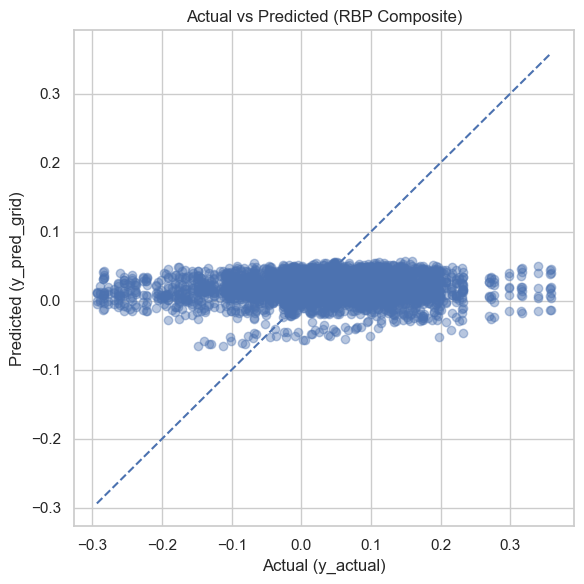

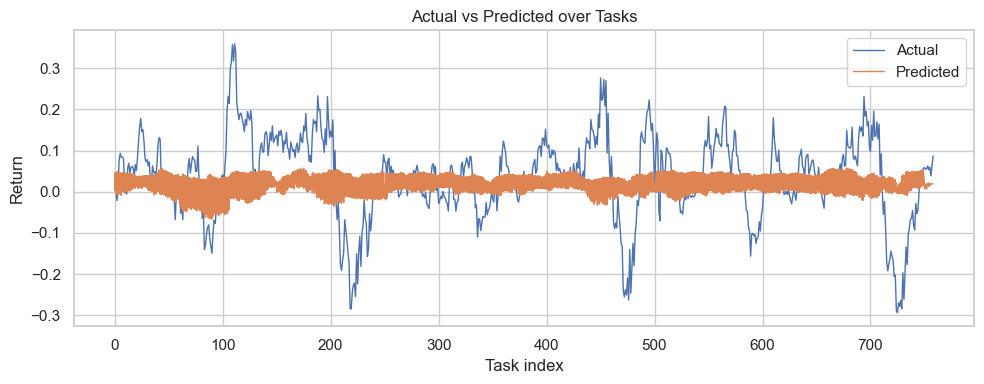

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Sort in a sensible order
results_df_sorted = results_df_clean.sort_index()

y_true = results_df_sorted["y_actual"].to_numpy()
y_pred = results_df_sorted["y_pred_grid"].to_numpy()

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)

# 45-degree line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel("Actual (y_actual)")
plt.ylabel("Predicted (y_pred_grid)")
plt.title("Actual vs Predicted (RBP Composite)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))

results_df_sorted["y_actual"].plot(label="Actual", linewidth=1)
results_df_sorted["y_pred_grid"].plot(label="Predicted", linewidth=1)

plt.xlabel(
    "Task index"
    if not np.issubdtype(results_df_sorted.index.dtype, np.datetime64)
    else "Date"
)
plt.ylabel("Return")
plt.title("Actual vs Predicted over Tasks")
plt.legend()
plt.tight_layout()
plt.show()



In [24]:
# Cell 10: Analysis & Visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_informativeness(X, x_mean, inv_cov):
    """
    Calculates info(x, x̄) for all rows in X as the squared Mahalanobis
    distance between each observation and the training mean x̄.
    
    Parameters
    ----------
    X : pd.DataFrame
        DataFrame of predictors (same columns as X_train).
    x_mean : np.ndarray
        Mean vector of training data (shape (K,)).
    inv_cov : np.ndarray
        Inverse covariance matrix of training data (shape (K, K)).
    
    Returns
    -------
    pd.Series
        Informativeness scores indexed like X (one per row).
    """
    X_values = X.values
    x_mean_vec = np.asarray(x_mean)
    
    info_scores = []
    for row in X_values:
        d2 = calculate_mahalanobis_distance(row, x_mean_vec, inv_cov)
        info_scores.append(d2)
    
    return pd.Series(info_scores, index=X.index, name="informativeness")
# --- 1. Aggregate Importance Comparison (tau-like statistic) ---

# 1) Informativeness scores for each test task
info_scores_test = calculate_informativeness(
    X_test,
    full_train_stats['x_mean'],
    full_train_stats['inv_cov']
)

# 2) Convert to weights (normalized informativeness)
info_weights = info_scores_test / info_scores_test.sum()

# 3) Info-weighted average RBI per variable
#    (aligns tasks in rbi_df rows with info_weights index)
average_rbi = rbi_df.mul(info_weights, axis=0).sum()

# 4) Comparison table: OLS t-stats vs info-weighted RBI
comparison_df = pd.DataFrame({
    "t_statistic": ols_t_stats,
    "info_weighted_rbi": average_rbi
})

print("--- Aggregate Importance Comparison ---")
print(comparison_df.sort_values(by="info_weighted_rbi", ascending=False))
comparison_df.to_csv("importance_comparison.csv")

--- Aggregate Importance Comparison ---
                  t_statistic  info_weighted_rbi
past_return_252d       4.2968             0.0191
past_vol_21d           6.7777             0.0157
past_return_63d        6.6269             0.0145
past_vol_63d           1.5462             0.0092
past_return_21d        0.5007             0.0041


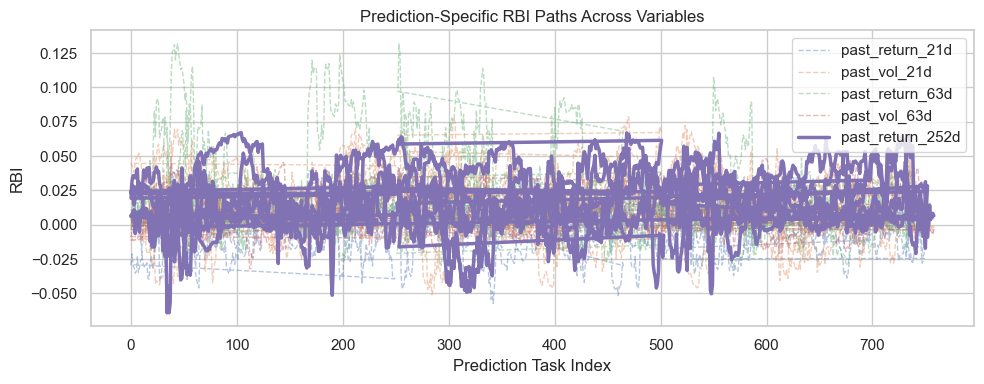

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure rbi_df and results_df_clean are aligned on the same index
rbi_aligned = rbi_df.reindex(results_df_clean.index)

plt.figure(figsize=(10, 4))

for col in rbi_aligned.columns:
    if col == "past_return_252d":
        # Highlight this one
        plt.plot(
            rbi_aligned.index,
            rbi_aligned[col],
            label=col,
            linewidth=2.5,
        )
    else:
        plt.plot(
            rbi_aligned.index,
            rbi_aligned[col],
            label=col,
            linewidth=1,
            alpha=0.4,
            linestyle="--",
        )

plt.xlabel("Prediction Task Index")
plt.ylabel("RBI")
plt.title("Prediction-Specific RBI Paths Across Variables")
plt.legend()
plt.tight_layout()
plt.show()


Fetching 10 years of AAPL data from FMP...
Fetched 2749 rows for AAPL.
     timestamp  open_price  high_price  low_price  close_price  adjClose  \
251 2015-01-02     27.8500     27.8600    26.8400      27.3300   24.2300   
250 2015-01-05     27.0700     27.1600    26.3500      26.5600   23.5500   
249 2015-01-06     26.6400     26.8600    26.1600      26.5700   23.5600   
248 2015-01-07     26.8000     27.0500    26.6700      26.9400   23.8800   
247 2015-01-08     27.3100     28.0400    27.1800      27.9700   24.8000   

        volume  unadjustedVolume  change  changePercent    vwap  \
251  212818504         212818504 -0.5150        -1.8700 27.4700   
250  257142000         257142000 -0.5100        -1.8800 26.7850   
249  263188464         263188464 -0.0700        -0.2628 26.5575   
248  160423736         160423736  0.1375         0.5224 26.8650   
247  237458188         237458188  0.6650         2.4200 27.6250   

              label  changeOverTime ticker  
251  January 02, 15     

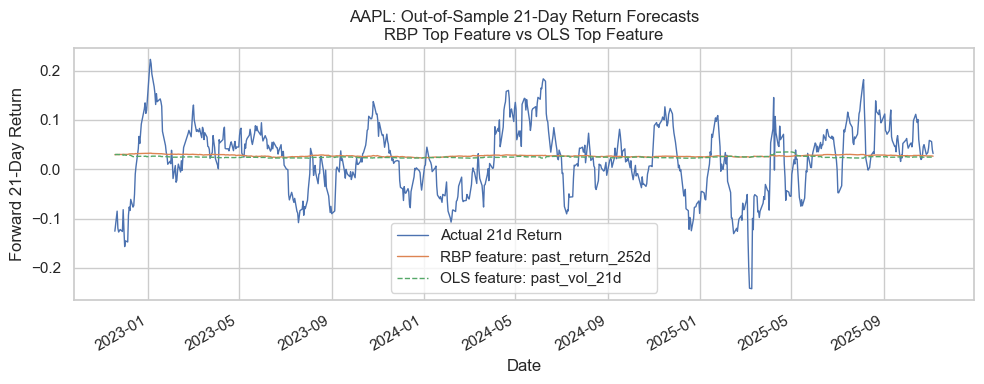

In [27]:
# ==========================================================
# New Cell: AAPL 10-year horse race (RBP vs OLS top feature)
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1. Fetch 10 years of AAPL data via FMP API
aapl_lookback_days = 365 * 10  # ~10 years

if not fmp_api_key:
    raise ValueError("FMP_API_KEY not found. Please set it before running this cell.")

print("Fetching 10 years of AAPL data from FMP...")
aapl_data = _get_market_data(["AAPL"], aapl_lookback_days, fmp_api_key)

print(f"Fetched {len(aapl_data)} rows for AAPL.")
print(aapl_data.head())

# 2. Engineer RBP features and target using the existing pipeline
# Assumes engineer_features, FEATURE_COLS, TARGET_COL are already defined.
aapl_proc = engineer_features(aapl_data.copy())

# Ensure sorted by time and use timestamp as index
aapl_proc = aapl_proc.sort_values("timestamp").set_index("timestamp")

X_aapl = aapl_proc[FEATURE_COLS]
y_aapl = aapl_proc[TARGET_COL]

# Drop any remaining NaNs (just in case)
valid_mask = X_aapl.notna().all(axis=1) & y_aapl.notna()
X_aapl = X_aapl.loc[valid_mask]
y_aapl = y_aapl.loc[valid_mask]

print("AAPL feature matrix shape:", X_aapl.shape)

# 3. Time-based train/test split (e.g., 70% train, 30% test)
split_idx = int(0.7 * len(X_aapl))
split_date = X_aapl.index[split_idx]

train_mask = X_aapl.index < split_date
test_mask = ~train_mask

X_train_aapl = X_aapl.loc[train_mask]
y_train_aapl = y_aapl.loc[train_mask]

X_test_aapl = X_aapl.loc[test_mask]
y_test_aapl = y_aapl.loc[test_mask]

print(f"Train size: {len(X_train_aapl)}, Test size: {len(X_test_aapl)}")

# 4. Choose features:
#    - RBP top feature (info-weighted RBI): past_return_252d
#    - OLS top feature (|t-statistic|): past_vol_21d
rbp_feature = "past_return_252d"
ols_feature = "past_vol_21d"

assert rbp_feature in X_aapl.columns, f"{rbp_feature} not in FEATURE_COLS"
assert ols_feature in X_aapl.columns, f"{ols_feature} not in FEATURE_COLS"

Xr_train = X_train_aapl[[rbp_feature]]
Xr_test = X_test_aapl[[rbp_feature]]

Xt_train = X_train_aapl[[ols_feature]]
Xt_test = X_test_aapl[[ols_feature]]

# 5. Helper: fit univariate OLS and predict
def fit_univariate_ols(X_train, y_train, X_test):
    Xtr = sm.add_constant(X_train)
    Xte = sm.add_constant(X_test)
    model = sm.OLS(y_train, Xtr).fit()
    y_hat = model.predict(Xte)
    return model, y_hat

model_rbp, y_hat_rbp = fit_univariate_ols(Xr_train, y_train_aapl, Xr_test)
model_ols, y_hat_ols = fit_univariate_ols(Xt_train, y_train_aapl, Xt_test)

# 6. Compute out-of-sample performance metrics
def rmse(y_true, y_hat):
    return float(np.sqrt(((y_true - y_hat) ** 2).mean()))

def mae(y_true, y_hat):
    return float((y_true - y_hat).abs().mean())

rmse_rbp = rmse(y_test_aapl, y_hat_rbp)
mae_rbp = mae(y_test_aapl, y_hat_rbp)

rmse_ols = rmse(y_test_aapl, y_hat_ols)
mae_ols = mae(y_test_aapl, y_hat_ols)

print("\n=== AAPL 10-Year Horse Race (Univariate Forecasts) ===")
print(f"RBP top feature ({rbp_feature}):      RMSE = {rmse_rbp:.5f}, MAE = {mae_rbp:.5f}")
print(f"OLS top feature ({ols_feature}):      RMSE = {rmse_ols:.5f}, MAE = {mae_ols:.5f}")

# 7. Plot actual vs both predictions on the test set
plt.figure(figsize=(10, 4))

# Align predictions with test index
y_hat_rbp.index = X_test_aapl.index
y_hat_ols.index = X_test_aapl.index

y_test_aapl.plot(label="Actual 21d Return", linewidth=1)
y_hat_rbp.plot(label=f"RBP feature: {rbp_feature}", linewidth=1)
y_hat_ols.plot(label=f"OLS feature: {ols_feature}", linewidth=1, linestyle="--")

plt.title("AAPL: Out-of-Sample 21-Day Return Forecasts\nRBP Top Feature vs OLS Top Feature")
plt.xlabel("Date")
plt.ylabel("Forward 21-Day Return")
plt.legend()
plt.tight_layout()
plt.show()


RBP visual scale factor (std_actual / std_rbp) = 36.54
OLS  visual scale factor (std_actual / std_ols) = 32.97


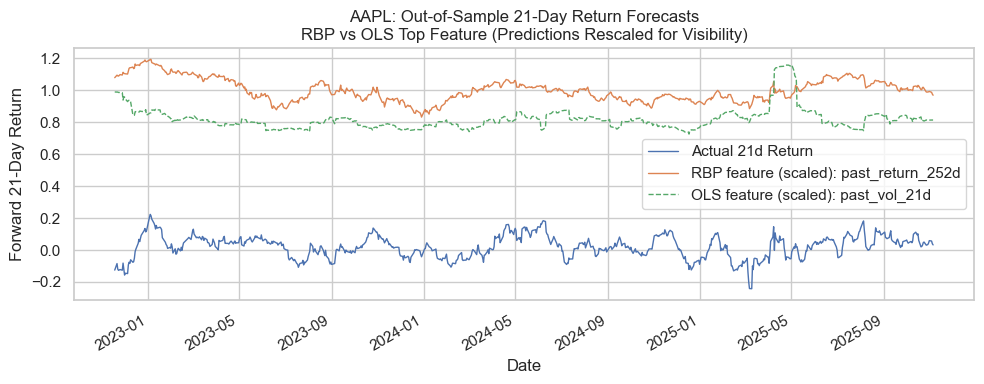

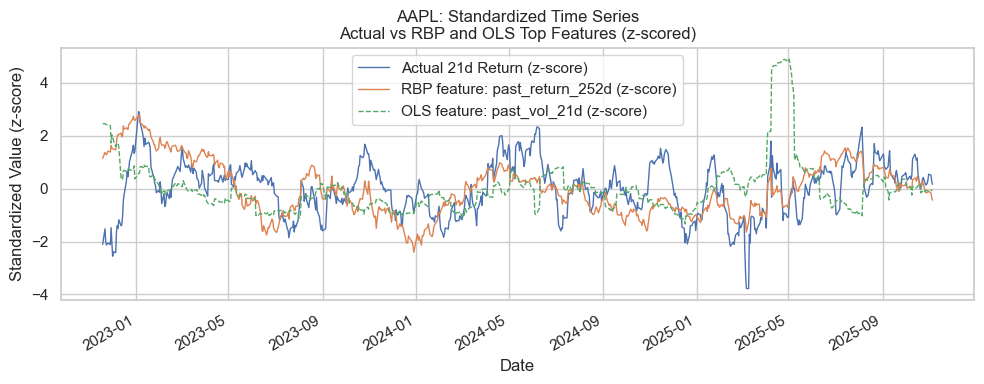

In [29]:
# ==========================================================
# Updated Cell: Visual magnifier + standardized time series
# ==========================================================

import matplotlib.pyplot as plt
import numpy as np

# Use the existing test series and predictions
# Assumes: y_test_aapl, y_hat_rbp, y_hat_ols, X_test_aapl, rbp_feature, ols_feature

# 1. Compute scale factors to match std dev of actual returns
std_actual = y_test_aapl.std()
std_rbp    = y_hat_rbp.std()
std_ols    = y_hat_ols.std()

if std_rbp == 0 or std_ols == 0:
    raise ValueError("One of the prediction series has zero variance; cannot scale meaningfully.")

scale_factor_rbp = std_actual / std_rbp
scale_factor_ols = std_actual / std_ols

print(f"RBP visual scale factor (std_actual / std_rbp) = {scale_factor_rbp:.2f}")
print(f"OLS  visual scale factor (std_actual / std_ols) = {scale_factor_ols:.2f}")

# 2. Build scaled series JUST FOR PLOTTING
y_hat_rbp_scaled = y_hat_rbp * scale_factor_rbp
y_hat_ols_scaled = y_hat_ols * scale_factor_ols

# Align indices
y_hat_rbp_scaled.index = X_test_aapl.index
y_hat_ols_scaled.index = X_test_aapl.index

# ----------------------------------------------------------
# Plot 1: Actual vs scaled predictions (what you already had)
# ----------------------------------------------------------
plt.figure(figsize=(10, 4))

y_test_aapl.plot(label="Actual 21d Return", linewidth=1)
y_hat_rbp_scaled.plot(label=f"RBP feature (scaled): {rbp_feature}", linewidth=1)
y_hat_ols_scaled.plot(label=f"OLS feature (scaled): {ols_feature}", linewidth=1, linestyle="--")

plt.title(
    "AAPL: Out-of-Sample 21-Day Return Forecasts\n"
    "RBP vs OLS Top Feature (Predictions Rescaled for Visibility)"
)
plt.xlabel("Date")
plt.ylabel("Forward 21-Day Return")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Plot 2: Standardized (z-score) time series of same three lines
# ----------------------------------------------------------

# z-score each series (mean 0, std 1)
z_actual = (y_test_aapl - y_test_aapl.mean()) / y_test_aapl.std()
z_rbp    = (y_hat_rbp - y_hat_rbp.mean()) / y_hat_rbp.std()
z_ols    = (y_hat_ols - y_hat_ols.mean()) / y_hat_ols.std()

# Align indices
z_rbp.index = X_test_aapl.index
z_ols.index = X_test_aapl.index

plt.figure(figsize=(10, 4))

z_actual.plot(label="Actual 21d Return (z-score)", linewidth=1)
z_rbp.plot(label=f"RBP feature: {rbp_feature} (z-score)", linewidth=1)
z_ols.plot(label=f"OLS feature: {ols_feature} (z-score)", linewidth=1, linestyle="--")

plt.title(
    "AAPL: Standardized Time Series\n"
    "Actual vs RBP and OLS Top Features (z-scored)"
)
plt.xlabel("Date")
plt.ylabel("Standardized Value (z-score)")
plt.legend()
plt.tight_layout()
plt.show()
